109.79834
110.64054
109.30205
[[1.1815605  0.         0.        ]
 [0.         0.17535661 0.        ]
 [0.         0.         1.4684768 ]]
[[0.69804263 0.         0.        ]
 [0.         0.01537497 0.        ]
 [0.         0.         1.078212  ]]
674.2406
[-0.20805766 -0.04195103]
[ 3.2499921e+02  2.9548633e-01 -1.5409872e+01]


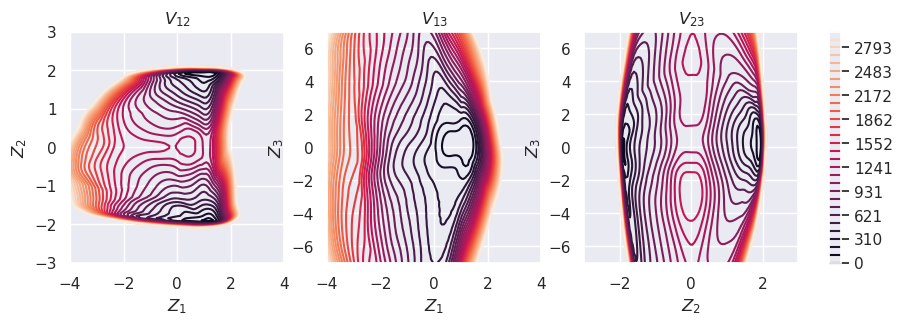

In [27]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme() 
from omegaconf import OmegaConf
from utils_reduced_polymer import PlotV

import jax.numpy as jnp
from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
def PlotV(net, config):
    # [-2.80463719 -1.9168483  -8.72728634] [1.23797143 1.91939402 8.81887722]
    z1_min, z1_max = -3, 2
    z2_min, z2_max = -3, 3
    z3_min, z3_max = -9, 9 
    z1_min, z1_max = -3, 3
    z2_min, z2_max = -2, 2
    z3_min, z3_max = -6, 6

    num_samples_aux_dimension = 128
    def V(z1, z2, z3):
        z = jnp.array([z1, z2, z3])
        return net.potential(z, [config.temperature]) 
    
    @jax.vmap
    @jax.jit
    def V_12(z1, z2):
        # z3_min, z3_max = -0.1, 0.1
        z3_test_range = jnp.linspace(z3_min, z3_max, num_samples_aux_dimension)
        return jnp.min(jax.vmap(V, (None, None, 0))(z1, z2, z3_test_range)) 

    @jax.vmap
    @jax.jit
    def V_13(z1, z3):
        z2_test_range = jnp.linspace(z2_min, z2_max, num_samples_aux_dimension)
        return jnp.min(jax.vmap(V, (None, 0, None))(z1, z2_test_range, z3)) 

    @jax.vmap
    @jax.jit
    def V_23(z2, z3):
        z1_test_range = jnp.linspace(z1_min, z1_max, num_samples_aux_dimension)
        return jnp.min(jax.vmap(V, (0, None, None))(z1_test_range, z2, z3)) 
    num_grid = 100
    num_levels = 30
    off_set = 1
    level_start = 0
    level_end = 3000.0

    custom_levels =  jnp.linspace(level_start, level_end, num_levels)
    # custom_levels=None

    # Define the range and number of points in each dimension
    z1_range = jnp.linspace(z1_min - off_set, z1_max + off_set, num_grid)
    z2_range = jnp.linspace(z2_min - off_set, z2_max + off_set, num_grid)
    z3_range = jnp.linspace(z3_min - off_set, z3_max + off_set, num_grid)

    fig, ax = plt.subplots(1, 3, figsize=(10,3)) 
    # V12
    Z1, Z2 = jnp.meshgrid(z1_range, z2_range)
    V12_grid = V_12(Z1.ravel(), Z2.ravel()).reshape(Z1.shape)
    V12_0 = jnp.min(V12_grid)
    print(V12_0)
    contour1 = ax[0].contour(Z1, Z2, V12_grid- V12_0, levels=custom_levels)
    ax[0].set_title(r'$V_{12}$')
    ax[0].set_xlabel(r'$Z_1$')
    ax[0].set_ylabel(r'$Z_2$')

    # V13
    Z1, Z3 = jnp.meshgrid(z1_range, z3_range)
    V13_grid = V_13(Z1.ravel(), Z3.ravel()).reshape(Z1.shape)
    V13_0 = jnp.min(V13_grid)
    print(V13_0)
    contour2 = ax[1].contour(Z1, Z3, V13_grid- V13_0, levels=custom_levels)
    ax[1].set_title(r'$V_{13}$')
    ax[1].set_xlabel(r'$Z_1$')
    ax[1].set_ylabel(r'$Z_3$')

    # V23
    Z2, Z3 = jnp.meshgrid(z2_range, z3_range)
    V23_grid = V_23(Z2.ravel(), Z3.ravel()).reshape(Z1.shape)
    V23_0 = jnp.min(V23_grid)
    print(V23_0)
    contour3 = ax[2].contour(Z2, Z3, V23_grid- V23_0, levels=custom_levels)
    ax[2].set_title(r'$V_{23}$')
    ax[2].set_xlabel(r'$Z_2$')
    ax[2].set_ylabel(r'$Z_3$')

    cbar = fig.colorbar(contour3, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)

from utils_reduced_polymer import build_OnsagerNetHD2_scale, build_OnsagerNet #, PlotV
path =  "outputs/main123_HD2" 

config = OmegaConf.load(os.path.join(path, ".hydra/config.yaml"))
model_template = build_OnsagerNetHD2_scale(config)   
# 读取 JAX 神经网络模型 
net = eqx.tree_deserialise_leaves(os.path.join(path,'F23_10_T0_25/model.eqx'), model_template)
PlotV(net, config)
print(net.diffusion(t=0, x= jnp.array([0.,0.,1.,]), args=[1]))
print(net.dissipation(x= jnp.array([1.,0.,1.,]))) 
print(net.potential(x= jnp.array([1,-2,0]), args=[1])) 
print(net.Hamiltonian(x= jnp.array([2.,2.,2.]))) 
print(net.drift(t=0, x= jnp.array([0.,0.,1.,]), args=[1]))


In [39]:
import jax.random as jr 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import os  
 

from examples.utils.sde import SDEIntegrator

import os
import pickle

# def PlotTraj(net, config, dataset_name="F23_10_T1"): 

def entropy_production_polymer(net, temperature=0.25):
    z1_min, z1_max = -3, 3
    z2_min, z2_max = -2, 2
    z3_min, z3_max = -6, 6

    init_unit = jr.uniform(
        key=jr.PRNGKey(123), shape=(1000,3)
    )
    bounds = jnp.array([[z1_min, z1_max],[z2_min, z2_max],[z3_min, z3_max]])
    init_conditions = bounds[:, 0] + (bounds[:, 1] - bounds[:, 0]) * init_unit 

    integrator = SDEIntegrator(model=net, state_dim=3)
    key = jr.PRNGKey(0) 
    bm_keys = jr.split(key, 1000) 
    sol = integrator.parallel_solve(
        key=bm_keys,
        initial_conditions=init_conditions,
        t0=0.0,
        t1=1,
        dt=0.0001,
        args=[temperature],
    )
    init_conditions = sol.ys[:, -1, :]
    sol2 = integrator.parallel_solve(
        key=bm_keys,
        initial_conditions=init_conditions,
        t0=0.0,
        t1=1,
        dt=0.0001,
        args=[temperature],
    )
    predicted_trajectories = sol2.ys

    def gamma_net(net):
        def gamma(x):
            args=[1]  
            dvdx = jax.grad(net.potential, argnums=0)(x, args)

            #compution of the gamma term
            H = net.Hamiltonian(x)
            grad_H = jax.jacfwd(net.Hamiltonian, argnums=0)(x)
            gamma_value = jnp.einsum('dab,db->a', net.J, grad_H) - jnp.einsum('d,dab,b->a', H, net.J, dvdx)
            return gamma_value
        return gamma

    def ep_term(gamma, dissipation):
        def ep_term_x(x):
            return gamma(x)@(jnp.linalg.inv(dissipation(x))@gamma(x))
        return ep_term_x

    ep_term = ep_term(gamma_net(net), net.dissipation)
    x= predicted_trajectories[:,int(0.75*2/0.0002):,].reshape(-1,3)
    ep = jax.vmap(ep_term)(x) 
    return ep.mean(), predicted_trajectories
    print(ep.mean())
ep, _ = entropy_production_polymer(net)
print(ep)

15.853944


In [38]:
print(_.shape)

(1000, 10000, 3)


[-0.24987674 -0.11156079 -0.00337508  0.12012018  0.20424777  0.3140376
  0.3732617   0.4432428   0.5268046   0.59285694]


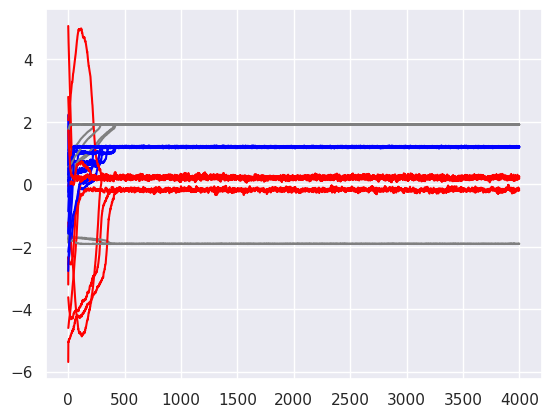

In [33]:
predicted_trajectories = _
for i in range(10):
    plt.plot(predicted_trajectories[i,:,0], color='blue')
    plt.plot(predicted_trajectories[i,:,1], color='grey')
    plt.plot(predicted_trajectories[i,:,2], color='red')

print(predicted_trajectories[i,:10,0])

TypeError: list indices must be integers or slices, not tuple